In [373]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, StratifiedKFold


In [375]:
df=pd.read_csv("Website Phishing.csv")
df.head()

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [377]:
# the data is already in numerical form .So I don't need any encoding here

In [379]:
print(f'Data shape (rows, columns): {df.shape}')
print(f'Number of duplicate rows: {df.duplicated().sum()}')
print(f'Number of missing values: {df.isnull().sum().sum()}\n')

df.info()

Data shape (rows, columns): (1353, 10)
Number of duplicate rows: 629
Number of missing values: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   SFH                1353 non-null   int64
 1   popUpWidnow        1353 non-null   int64
 2   SSLfinal_State     1353 non-null   int64
 3   Request_URL        1353 non-null   int64
 4   URL_of_Anchor      1353 non-null   int64
 5   web_traffic        1353 non-null   int64
 6   URL_Length         1353 non-null   int64
 7   age_of_domain      1353 non-null   int64
 8   having_IP_Address  1353 non-null   int64
 9   Result             1353 non-null   int64
dtypes: int64(10)
memory usage: 105.8 KB


In [381]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SFH,1353.0,0.237990,0.916389,-1.0,-1.0,1.0,1.0,1.0
popUpWidnow,1353.0,-0.258684,0.679072,-1.0,-1.0,0.0,0.0,1.0
SSLfinal_State,1353.0,0.327421,0.822193,-1.0,0.0,1.0,1.0,1.0
Request_URL,1353.0,-0.223208,0.799682,-1.0,-1.0,0.0,0.0,1.0
URL_of_Anchor,1353.0,-0.025129,0.936262,-1.0,-1.0,0.0,1.0,1.0
web_traffic,1353.0,0.000000,0.806776,-1.0,-1.0,0.0,1.0,1.0
URL_Length,1353.0,-0.053215,0.762552,-1.0,-1.0,0.0,1.0,1.0
age_of_domain,1353.0,0.219512,0.975970,-1.0,-1.0,1.0,1.0,1.0
having_IP_Address,1353.0,0.114560,0.318608,0.0,0.0,0.0,0.0,1.0
Result,1353.0,-0.113821,0.954773,-1.0,-1.0,-1.0,1.0,1.0


In [383]:
# User defined fonction for counting and percentage values in the each column

def get_value_count(df, column_name):
    vc = df[column_name].value_counts()
    vc_norm = df[column_name].value_counts(normalize=True)

    vc = vc.rename_axis(column_name).reset_index(name='counts')
    vc_norm = vc_norm.rename_axis(column_name).reset_index(name='percent')

    df_result = pd.concat([vc[column_name], vc['counts'], vc_norm['percent']], axis=1)
    
    return df_result

In [385]:
# Distributions of the Target Feature: Result
# 1: Legitimate
# 0: Suspicious
# -1: Phishing

In [387]:
get_value_count(df, 'Result') 

,Result,counts,percent
0,-1,702,0.518847
1,1,548,0.405026
2,0,103,0.076127


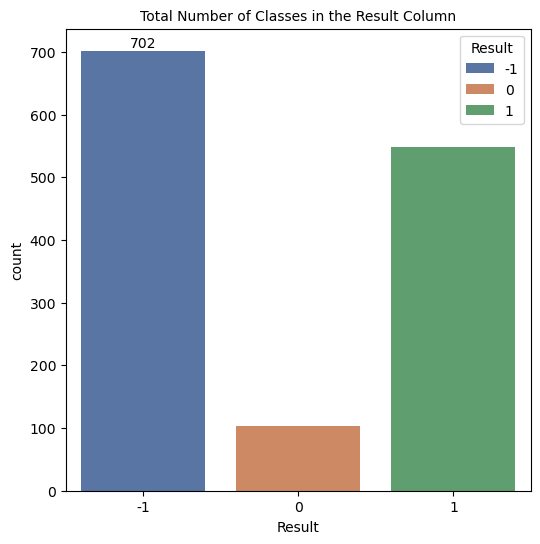

In [389]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df, x="Result", hue="Result", palette='deep')


ax.bar_label(ax.containers[0])
ax.set_title('Total Number of Classes in the Result Column', size = 10);
plt.show()

Converting Phishing (-1) to Suspicious (0)

The Suspicious (0) class has a very low number of values
To mitigate this risk, we will merge the Suspicious (0) class with the Phishing (-1) class
So we will have only 2 classes:

Legitimate URLs (1) (Good)
Phishing URLs (0) (Bad)
The other feature columns were kept in their original form [-1, 0, 1 values] to preserve their semantic meaning and the model's learning capacity.

Converting these feature columns would have resulted in the loss of important information since each value represents specific conditions that help the model make better distinctions between legitimate and phishing URLs

In [392]:
# replace Suspicious (0) values with Phishing (-1) in the "Result columns"

df['Result'] = df['Result'].replace(-1, 0)

get_value_count(df, 'Result') 

,Result,counts,percent
0,0,805,0.594974
1,1,548,0.405026


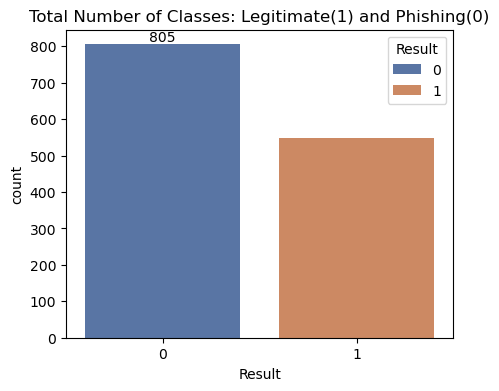

In [394]:
plt.figure(figsize=(5,4))
ax = sns.countplot(data=df, x="Result", hue="Result", palette='deep')

ax.bar_label(ax.containers[0])
ax.set_title('Total Number of Classes: Legitimate(1) and Phishing(0)', size = 12);
plt.show()

Correlations 

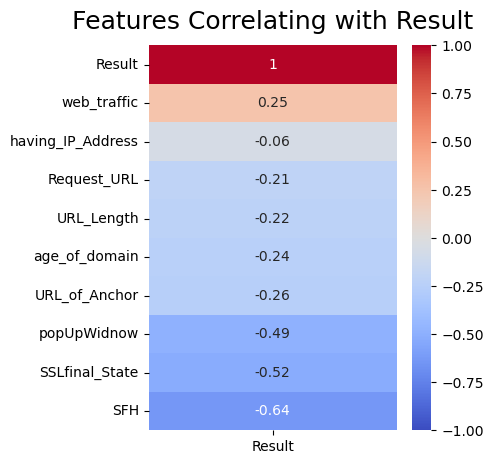

In [397]:
plt.figure(figsize=(4, 5))
heatmap = sns.heatmap(df.corr()[['Result']].sort_values(by='Result', ascending=False), vmin=-1, vmax=1, annot=True, cmap = 'coolwarm')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmapfeaturecorr.png', dpi=300, bbox_inches='tight')

In [398]:
#Splitting Data
X = df.drop('Result', axis = 1)
y = df['Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


print('---------------------------------------------')
print("X_Train rows-columns: ", X_train.shape)
print("y_Train Target Feature rosw: ", y_train.shape)
print("X_Test Validation Data rows-columns: ", X_test.shape)
print('---------------------------------------------')
print("Prediction Test Dataset rows-columns: ", y_test.shape)
print('---------------------------------------------')

---------------------------------------------
X_Train rows-columns:  (1082, 9)
y_Train Target Feature rosw:  (1082,)
X_Test Validation Data rows-columns:  (271, 9)
---------------------------------------------
Prediction Test Dataset rows-columns:  (271,)
---------------------------------------------


We don't need to apply standardization to this dataset as it is already in the standard form and so Logistic regressiin,KNN,etc. models can be directly applied to it

In [402]:
X_train.head(3)

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
856,1,-1,0,1,1,0,-1,1,0
1297,1,0,1,-1,1,0,1,-1,0
1296,1,0,-1,1,1,1,1,-1,0


In [404]:
X_test.head(3)

,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address
673,1,0,1,1,1,1,1,1,1
552,1,0,1,-1,1,0,0,-1,0
226,1,1,1,-1,-1,-1,1,1,0


In [406]:
# User-Defined-Functions

#-----------------------------------------------------

# Function to Evaluate the Model Performans using Classification Confusion_matrix() 
# Also does the prediction in the function

def eval_metric(model, X_train, y_train, X_test, y_test, i):

    """ to get the metrics for the model """

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(f"{i} Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print(f"{i} Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))
    
# -----------------------------------------------------

# Function to display Feature Importance
def plot_feature_importance(model, X_train, model_name, figsize=(8, 5)):
    """
    Plots the feature importances of a fitted model as a horizontal bar plot,
    with the importance values displayed next to the bars.
    """
    # Get feature importances
    feature_importances = model.feature_importances_
    
    # Create a Series for feature importances
    feats = pd.Series(data=feature_importances, index=X_train.columns).sort_values(ascending=False)
    
    # Plot the feature importances as a horizontal bar plot
    plt.figure(figsize=figsize)
    sns.barplot(y=feats.index, x=feats.values, orient='h', palette='Blues')

    # Add the importance values next to the bars
    for index, value in enumerate(feats.values):
        plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

    # Add model name to the plot title
    plt.title(f"Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

In [408]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [409]:
# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
# Metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, precision_recall_curve
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from yellowbrick.classifier import PrecisionRecallCurve, ClassPredictionError, ROCAUC
from yellowbrick.regressor import ResidualsPlot, PredictionError

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [410]:
# Comparing the Classifier Models

random_state = 42 #for reproducibility

kfold = StratifiedKFold(n_splits=10)

classifiers = []
classifiers.append(LogisticRegression(random_state=random_state, max_iter=1000))
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(XGBClassifier(random_state=random_state))

In [411]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, 
                                      X_train, 
                                      y = y_train, 
                                      scoring = "accuracy", 
                                      cv = kfold, n_jobs=4,verbose=1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["LogisticRegression","KNeighbors",
"DecisionTree","RandomForest","XGBoost"]})

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished


In [412]:
cv_res.sort_values(by = 'CrossValMeans', ascending = False)
# from the following we'll choose the models as our classifiers.

,CrossValMeans,CrossValerrors,Algorithm
3,0.907586,0.032258,RandomForest
4,0.904817,0.027104,XGBoost
1,0.891854,0.024542,KNeighbors
2,0.875246,0.026441,DecisionTree
0,0.859446,0.036013,LogisticRegression


In [413]:
#RandomForest Classifier

In [414]:
import numpy as np

print(np.isnan(X_train).sum().sum())  # Total NaNs
print(np.isinf(X_train).sum().sum())  # Total Infs


0
0


In [415]:
# RF Hyperparameters Tuning with GridSearchSV 

from sklearn.model_selection import GridSearchCV

# Reset the model
model = RandomForestClassifier(random_state=random_state)


param_grid = {           
            'n_estimators': [50,100],  
            'max_depth': [None, 2, 10],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2,5],
            'max_features': ['sqrt', 'log2'],
            'max_samples':[0.5, 0.9],
            "criterion": ["gini", "entropy"]
             }
             


cv = StratifiedKFold(n_splits=5)

# GridSearchCV
RFC_grid_model = GridSearchCV(model,
                          param_grid=param_grid,
                          cv=cv,
                          scoring="accuracy",  
                          n_jobs=4,          # Use all available cores
                          verbose=1,
                          return_train_score=True).fit(X_train, y_train) # Fit the grid search model

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [416]:
rfc_best_params = RFC_grid_model.best_params_
rfc_best_scores = RFC_grid_model.best_score_
print('Best Params:', rfc_best_params)
print('Best Recall Score(test):', rfc_best_scores)
print('-----------------------------------------------------')

# Checking overfiting of Grid Model with the CV scores
pd.DataFrame(RFC_grid_model.cv_results_).loc[RFC_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

Best Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Recall Score(test): 0.9158986175115207
-----------------------------------------------------


mean_test_score     0.915899
mean_train_score    0.942005
Name: 107, dtype: object

In [418]:
# Create a new model with the best parameters from GridSearchCV
RFC_best_model  = RandomForestClassifier(
    **rfc_best_params,  # Unpack the best parameters dictionary
    random_state=random_state,
    #verbose=1
)

# Fit the model on the training data
RFC_best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [419]:
# Make predictions on test data
y_pred = RFC_best_model.predict(X_test)

# Evaluate the model
RFC_best_acc = accuracy_score(y_test, y_pred)
print('RFC_best_model_accuracy score with the Test prediction: ',RFC_best_acc, '\n')

target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))

RFC_best_model_accuracy score with the Test prediction:  0.915129151291513 

              precision    recall  f1-score   support

    Phishing       0.94      0.91      0.93       161
  Legitamite       0.88      0.92      0.90       110

    accuracy                           0.92       271
   macro avg       0.91      0.92      0.91       271
weighted avg       0.92      0.92      0.92       271



C:\Users\Pushp\AppData\Local\Temp\ipykernel_24380\2087118780.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feats.index, x=feats.values, orient='h', palette='Blues')


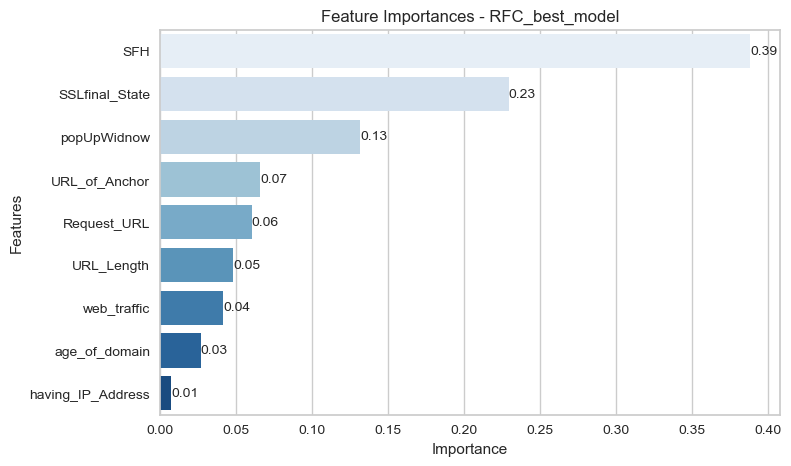

In [422]:
# Feature Importance
plot_feature_importance(RFC_best_model, X_test, 'RFC_best_model')

In [423]:
# XGBoost Classifier
# XGBoosting Hyperparameters Tuning with GridSearchSV 
from xgboost import XGBClassifier

# Reset the model
model = XGBClassifier(random_state=random_state, verbose=-1)

# Define the hyperparameters grid for tuning
param_grid = {
    "booster": ['dart', 'gbtree'],
    "eta": [0.05, 0.1],
    "n_estimators": [100, 150],
    'max_depth': [2, 3],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    'reg_alpha': [0, 0.5]
}

cv = StratifiedKFold(n_splits=5)

# GridSearchCV
XGB_grid_model  = GridSearchCV(model,
                          param_grid=param_grid,
                          cv=cv,
                          scoring="accuracy",   
                          n_jobs=4,          # Use all available cores
                          verbose=1,
                          return_train_score=True).fit(X_train, y_train) # Fit the grid search model

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


In [424]:
xgb_best_params = XGB_grid_model.best_params_
xgb_best_scores = XGB_grid_model.best_score_
print('Best Params:', xgb_best_params)
print('Best Recall Score(test):', xgb_best_scores)
print('-----------------------------------------------------')

# Checking overfiting of Grid Model with the CV scores
pd.DataFrame(XGB_grid_model.cv_results_).loc[XGB_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

Best Params: {'booster': 'dart', 'colsample_bytree': 0.8, 'eta': 0.05, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'reg_alpha': 0, 'subsample': 0.8}
Best Recall Score(test): 0.914042498719918
-----------------------------------------------------


mean_test_score     0.914042
mean_train_score    0.944315
Name: 93, dtype: object

In [425]:
#Prediction with Best HyperParameters

In [426]:
# Create a new XGB model with the best parameters from GridSearchCV
XGB_best_model  = XGBClassifier(
    **xgb_best_params,  # Unpack the best parameters dictionary
    random_state=random_state,
    verbose=1
)

# Fit the model on the training data
XGB_best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, ...)

In [427]:
# Make predictions on test data
y_pred = XGB_best_model.predict(X_test)

# Evaluate the model
XGB_best_acc = accuracy_score(y_test, y_pred)
print('XGB_best_model_accuracy score with the Test prediction: ',XGB_best_acc, '\n')

target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))

XGB_best_model_accuracy score with the Test prediction:  0.9003690036900369 

              precision    recall  f1-score   support

    Phishing       0.95      0.88      0.91       161
  Legitamite       0.84      0.93      0.88       110

    accuracy                           0.90       271
   macro avg       0.89      0.90      0.90       271
weighted avg       0.90      0.90      0.90       271



C:\Users\Pushp\AppData\Local\Temp\ipykernel_24380\2087118780.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=feats.index, x=feats.values, orient='h', palette='Blues')


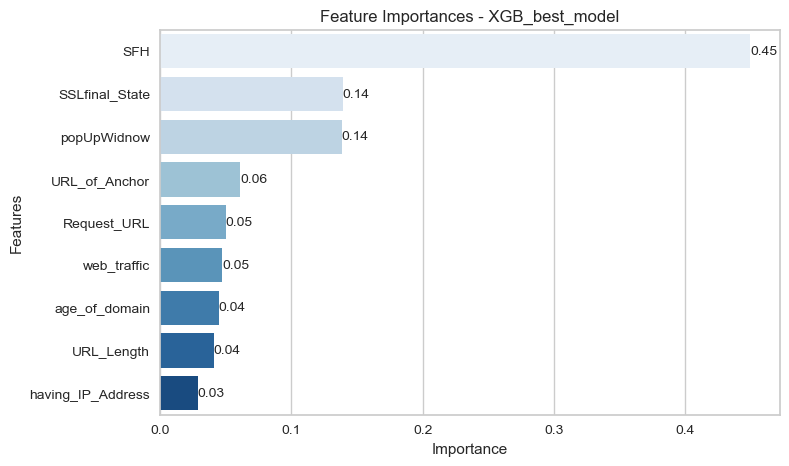

In [428]:
# Feature Importance
plot_feature_importance(XGB_best_model, X_test, 'XGB_best_model')

Stacking models

In [430]:
# Define base models
base_models = [
    ('rf', RandomForestClassifier(**rfc_best_params,random_state=random_state)),
    ('xgb', XGBClassifier(**xgb_best_params,random_state=random_state,  eval_metric='logloss'))
]

# Define meta model
meta_model = LogisticRegression(random_state=random_state)

# Create the StackingClassifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [431]:
# Define the parameter grid for GridSearch
param_grid = {
    # Meta-learner parameters
    'final_estimator__C': [0.1, 1.0, 10.0],
    'final_estimator__solver': ['liblinear', 'saga']
}

cv = StratifiedKFold(n_splits=5)

# Apply GridSearchCV
STACK_grid_model = GridSearchCV(estimator=stacking_model,
                           param_grid=param_grid,
                           scoring="accuracy",
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

# Fit the model
STACK_grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=StackingClassifier(cv=5,
                                          estimators=[('rf',
                                                       RandomForestClassifier(criterion='entropy',
                                                                              max_samples=0.9,
                                                                              min_samples_leaf=2,
                                                                              min_samples_split=10,
                                                                              random_state=42)),
                                                      ('xgb',
                                                       XGBClassifier(base_score=None,
                                                                     booster='dart',
                                                                     callbacks=None,
                                                                     colsample_bylevel=None,
                                                                     colsample_bynod...
                                                                     max_delta_step=None,
                                                                     max_depth=3,
                                                                     max_leaves=None,
                                                                     min_child_weight=None,
                                                                     missing=nan,
                                                                     monotone_constraints=None,
                                                                     multi_strategy=None,
                                                                     n_estimators=150,
                                                                     n_jobs=None, ...))],
                                          final_estimator=LogisticRegression(random_state=42)),
             n_jobs=-1,
             param_grid={'final_estimator__C': [0.1, 1.0, 10.0],
                         'final_estimator__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [432]:
stack_best_params = STACK_grid_model.best_params_
stack_best_scores = STACK_grid_model.best_score_
print('Best Params:', stack_best_params)
print('Best Recall Score(test):', stack_best_scores)
print('-----------------------------------------------------')

Best Params: {'final_estimator__C': 1.0, 'final_estimator__solver': 'saga'}
Best Recall Score(test): 0.9140552995391704
-----------------------------------------------------


In [433]:
#Prediction with Best HyperParameters

In [434]:
# Create the best meta-learner with optimized parameters
best_meta_model = LogisticRegression(
    C=stack_best_params['final_estimator__C'],
    solver=stack_best_params['final_estimator__solver'],
    random_state=random_state,
    verbose=1
)

# Create the best stacking model
STACK_best_model = StackingClassifier(
    estimators=base_models,
    final_estimator=best_meta_model,
    cv=5
)

# Fit the model on the training data
STACK_best_model.fit(X_train, y_train)

convergence after 14 epochs took 0 seconds


StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_samples=0.9,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster='dart',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=...
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=150, n_jobs=None, ...))],
                   final_estimator=LogisticRegression(random_state=42,
                                                      solver='saga',
                                                      verbose=1))

In [439]:
 # Make predictions on test data
y_pred = STACK_best_model.predict(X_test)

# Evaluate the model
STACK_best_acc = accuracy_score(y_test, y_pred)
print('STACK_best_model_accuracy score with the Test prediction: ',STACK_best_acc, '\n')

target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))

STACK_best_model_accuracy score with the Test prediction:  0.915129151291513 

              precision    recall  f1-score   support

    Phishing       0.94      0.91      0.93       161
  Legitamite       0.88      0.92      0.90       110

    accuracy                           0.92       271
   macro avg       0.91      0.92      0.91       271
weighted avg       0.92      0.92      0.92       271



Comparing all the Models

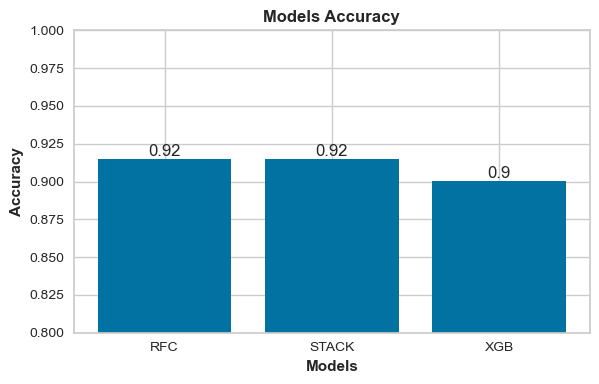

In [441]:
 # All the Models Accuracy Scores
accuracy_dict = {
    'RFC': RFC_best_acc,
    'XGB': XGB_best_acc,
    'STACK': STACK_best_acc
}

sorted_accuracy_dict = dict(sorted(accuracy_dict.items(), key=lambda item: item[1], reverse=True))

# Plotting accuracy scores
plt.figure(figsize=(6, 4))
bars = plt.bar(list(sorted_accuracy_dict.keys()), list(sorted_accuracy_dict.values()))

# Adding annotations
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(height, 2), ha='center', va='bottom')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Models Accuracy', fontweight='bold')
plt.tight_layout()
plt.ylim(0.8, 1)
plt.show()


In [442]:
#Best models are RFC and Stack

In [443]:
# Save Random Forest model

import joblib

joblib.dump(RFC_best_model, 'RFC_best_model.joblib')
print("Model saved successfully")

Model saved successfully


In [444]:
RFC_best_model

RandomForestClassifier(criterion='entropy', max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [445]:
# Load the model with best parameters
RFC_model_loaded = joblib.load('RFC_best_model.joblib')
print("Model loaded successfully")

RFC_model_loaded

Model loaded successfully


RandomForestClassifier(criterion='entropy', max_samples=0.9, min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

In [446]:
# Make predictions on test data
y_pred = RFC_model_loaded.predict(X_test)

# Evaluate the model
RFC_best_acc = accuracy_score(y_test, y_pred)
print('RFC_best_model_accuracy score with the Test prediction: ',RFC_best_acc, '\n')

target_names = ['Phishing', 'Legitamite']
print(classification_report(y_test, y_pred, target_names=target_names))

RFC_best_model_accuracy score with the Test prediction:  0.915129151291513 

              precision    recall  f1-score   support

    Phishing       0.94      0.91      0.93       161
  Legitamite       0.88      0.92      0.90       110

    accuracy                           0.92       271
   macro avg       0.91      0.92      0.91       271
weighted avg       0.92      0.92      0.92       271



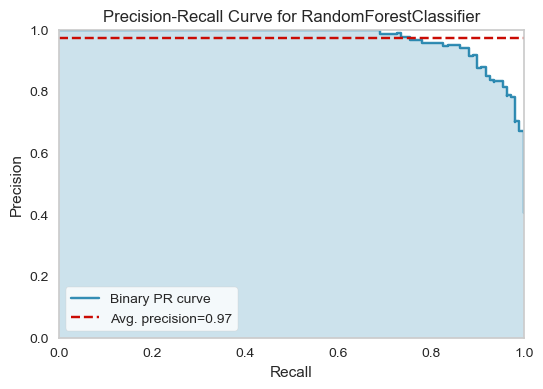

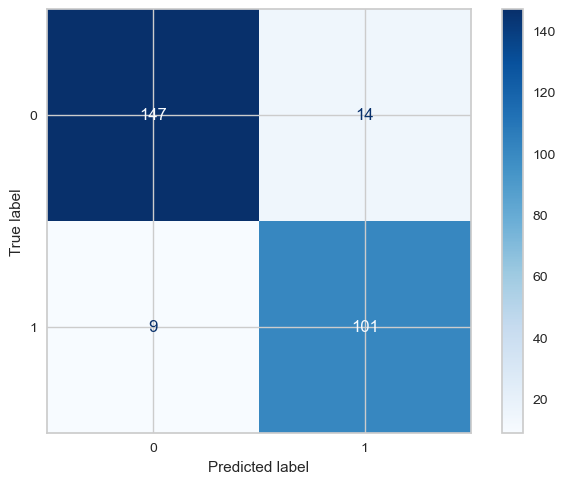

In [447]:
# Precision-Recall Curve
plt.figure(figsize=(6, 4))
viz = PrecisionRecallCurve(RFC_model_loaded)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(RFC_best_model, X_test, y_test, cmap='Blues')

Conclusion
RandomForestClassifier model performance:

RFC model shows strong performance in classifying phishing versus legitimate cases:

Accuracy: 91.5% accuracy on the test set, meaning the model correctly classified about 9 out of 10 samples overall.
Phishing Detection: 94% precision and 91% recall for phishing cases. This means when the model predicts something is phishing, it's right 94% of the time, and it catches 91% of all actual phishing instances.
Legitimate Classification: 88% precision and 92% recall for legitimate cases. The model is slightly better at identifying legitimate cases (higher recall) than being confident about them (lower precision).
Precision-Recall Curve: The first image shows an excellent PR curve with an average precision of 0.97. The curve remains high across different recall thresholds, dropping only at very high recall values.
Confusion Matrix: The second image confirms excellent performance with 147 true negatives and 101 true positives. There are only 14 false positives and 9 false negatives.
In summary, this model performs very well for phishing detection with balanced precision and recall, making it reliable for practical application.